# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum()


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [6]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
#total of missing data
print('The total number of missing data is {0}'.format(azdias.isnull().sum().sum()))

The total number of missing data is 4896838


In [8]:
#replace the missing value to NaNs
cols = feat_info['attribute'].values
values = ['-1','0','1','9']
#values_dict={} pleassss worrkkk
for j,col in enumerate(cols):
    missing_unknown = feat_info[feat_info.attribute==col]['missing_or_unknown'].values
    for i in range(len(missing_unknown)):
        missing_unknown[i] = missing_unknown[i].strip('[').strip(']').split(',')

    for i in range(len(missing_unknown[0])):
        if missing_unknown[0][i] in values:
                missing_unknown[0][i] = int(missing_unknown[0][i])
                
    azdias[col] = azdias[col].replace(missing_unknown[0], np.nan)
   

In [9]:
print('The total number of missing data after conversion is {0}'.format(azdias.isnull().sum().sum()))

The total number of missing data after conversion is 8373929


In [10]:
azdias.isnull().sum().head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_value_per_column = (azdias.isnull().sum()/len(azdias))*100
missing_value_per_column.sort_values(ascending=False) #better view 

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

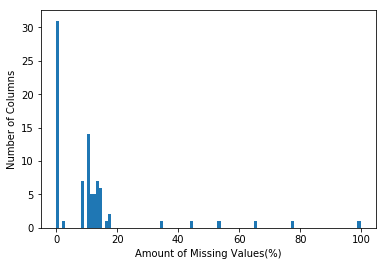

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_value_per_column, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Amount of Missing Values(%)')
plt.show()

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = missing_value_per_column[missing_value_per_column > 30]


In [14]:
drop_outlier_coloumns = outlier_columns.index.tolist()
print('Columns have more than 30% of missing values and will be droped:\n {0}'.format(drop_outlier_coloumns))

Columns have more than 30% of missing values and will be droped:
 ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [15]:
azdias = azdias.drop(drop_outlier_coloumns, axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?
missing_data_per_rows = azdias.isnull().sum(axis=1)

In [17]:
missing_data_per_rows.sort_values(ascending=False) #use sort

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

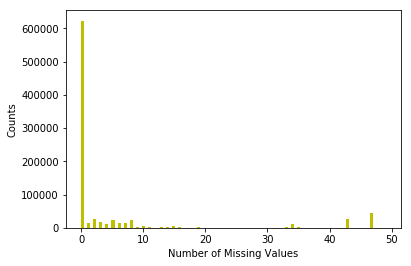

In [18]:
plt.hist(missing_data_per_rows,facecolor='y', bins=100)
plt.ylabel('Counts') #Number of Rows
plt.xlabel('Number of Missing Values')
plt.show()

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
lessm_values = azdias[azdias.isnull().sum(axis=1) < 30]
highm_values = azdias[azdias.isnull().sum(axis=1) >= 30]

print('Rows with missing values grater than 30: {0} which is {1}% of all data'.format(highm_values.shape[0], np.round(highm_values.shape[0]*100/azdias.shape[0],2)))
print('Rows with missing values less than 30: {0} which is {1}% of all data'.format(lessm_values.shape[0], np.round(lessm_values.shape[0]*100/azdias.shape[0],2)))
#print(highm_values.shape[0]*100/azdias.shape[0])

Rows with missing values grater than 30: 93160 which is 10.45% of all data
Rows with missing values less than 30: 798061 which is 89.55% of all data


In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_missing_values = missing_value_per_column[missing_value_per_column == 0].index.tolist()
no_missing_values

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

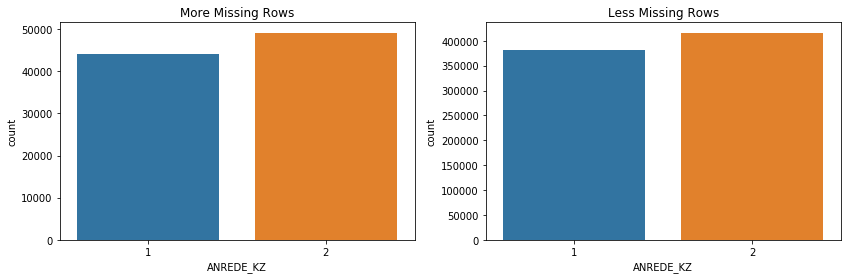

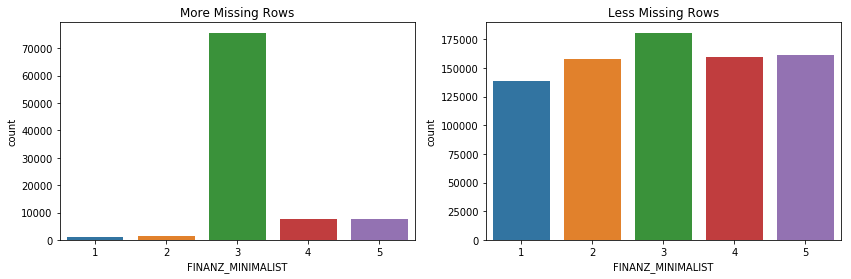

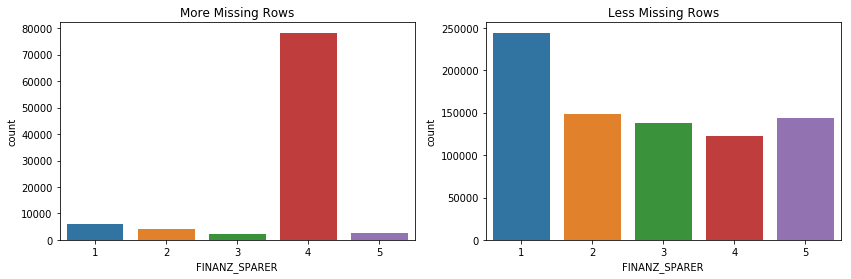

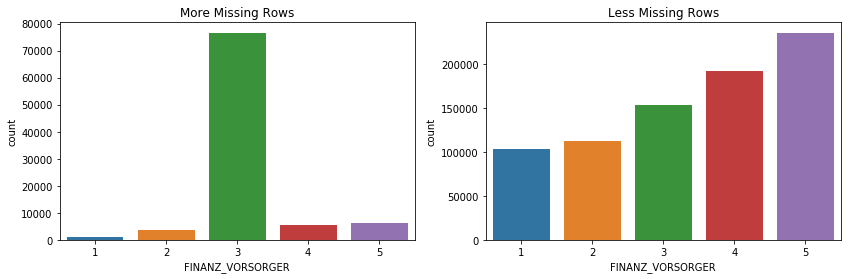

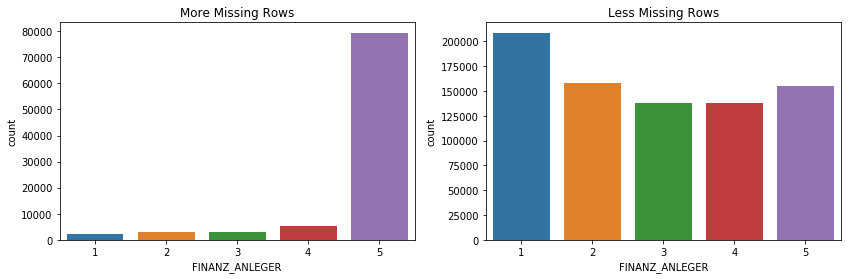

In [21]:
for i in range(5):
    fig = plt.figure(10, figsize=(14,4))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('More Missing Rows')
    sns.countplot(highm_values[no_missing_values[i]])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Less Missing Rows')
    sns.countplot(lessm_values[no_missing_values[i]])

    plt.show()

In [22]:
azdias_2 = lessm_values.copy()

In [23]:
azdias_2.isnull().sum().sort_values(ascending = False) #not now work with it at the end 

REGIOTYP                 64906
KKK                      64906
W_KEIT_KIND_HH           59302
LP_LEBENSPHASE_FEIN      50233
LP_LEBENSPHASE_GROB      47340
KBA05_ANTG4              40164
MOBI_REGIO               40164
KBA05_ANTG1              40164
KBA05_ANTG2              40164
KBA05_ANTG3              40164
KBA05_GBZ                40164
HEALTH_TYP               36721
SHOPPER_TYP              36721
VERS_TYP                 36721
NATIONALITAET_KZ         33918
LP_FAMILIE_GROB          31468
LP_FAMILIE_FEIN          31468
PRAEGENDE_JUGENDJAHRE    28755
PLZ8_HHZ                 23355
PLZ8_ANTG4               23355
PLZ8_GBZ                 23355
PLZ8_BAUMAX              23355
PLZ8_ANTG1               23355
PLZ8_ANTG2               23355
PLZ8_ANTG3               23355
KBA13_ANZAHL_PKW         12641
ANZ_HAUSHALTE_AKTIV       6460
CAMEO_DEU_2015            6198
CAMEO_DEUG_2015           6198
CAMEO_INTL_2015           6198
                         ...  
WOHNLAGE                     0
GREEN_AV

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

After we divide the data into two sets and compare them to specific column value we discover there is no bias. The missing data per row more than 30 was around 10% of the dataset. From the charts above we can see that the distributions of values in the two subsets were a little bit different. We will go ahead with a dataset of less than 30.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [25]:
features = list(lessm_values.columns)
feat_info_new = feat_info[feat_info['attribute'].isin(features)]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_val = feat_info.loc[feat_info["type"]=="categorical"]["attribute"]

#find features in azdias only
categorical_col = [categorical for categorical in categorical_val if categorical in azdias_2.columns]
categorical_col

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [27]:
#find binary and multi level features...
binary_feature =[]
mlevel_feature =[]

for i in categorical_col:
    if azdias_2[i].nunique() > 2:
        mlevel_feature.append(i)
    elif azdias_2[i].nunique() == 2:
        binary_feature.append(i)

#print
print('Multi-level features:\n{0}\n'.format(mlevel_feature))
print('Binary features:\n{0}'.format(binary_feature))

Multi-level features:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Binary features:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [28]:
print('Binary Features:\n')

for i in binary_feature:
    print('The {0} unique values is {1}\n'.format(i, azdias_2[i].unique()))

Binary Features:

The ANREDE_KZ unique values is [2 1]

The GREEN_AVANTGARDE unique values is [0 1]

The SOHO_KZ unique values is [ 1.  0.]

The VERS_TYP unique values is [  2.   1.  nan]

The OST_WEST_KZ unique values is ['W' 'O']



In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_2.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace=True)

In [30]:
azdias_2['OST_WEST_KZ'].unique() #make sure 

array([0, 1])

In [31]:
azdias_2.shape[1]

79

In [32]:
#Drop the multi-level ~ 
azdias_2.drop(mlevel_feature, axis=1, inplace= True)

In [33]:
azdias_2.shape[1] #done

66

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I did the following:

* Dropped all the multi-level features.
* Re-encoded the 'OST_WEST_KZ' values {w, o} to {0, 1}.
* I kept the binary features 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_2['DECADE'] = azdias_2['PRAEGENDE_JUGENDJAHRE'] 
azdias_2['MOVEMENT'] = azdias_2['PRAEGENDE_JUGENDJAHRE']

decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}


In [35]:
#replace
azdias_2['DECADE'].replace(decade_dict, inplace=True)
azdias_2['MOVEMENT'].replace(movement_dict, inplace=True)

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_2['WEALTH'] = azdias_2['CAMEO_INTL_2015']
azdias_2['LIFE_STAGE'] = azdias_2['CAMEO_INTL_2015']

wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [37]:
#replace
azdias_2['WEALTH'].replace(wealth_dict, inplace=True)
azdias_2['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I kept PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 for now, and perform the following engineering steps to the two mixed-value features:

1. I create two new feature columns and copy the values in the mixed feature into them.
2. I create two dictionaries and map the initial feature values to the new feature values.
3. Perform the replace operation using the dictionaries on the new feature columns. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_2.columns.values


array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_features = feat_info_new[feat_info_new["type"]=="mixed"]["attribute"]
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [41]:
for i in mixed_features:
    azdias_2.drop(i, axis=1, inplace=True)

In [42]:
azdias_2.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #replace the missing value to NaNs
    cols = feat_info['attribute'].values
    values = ['-1','0','1','9']
    #values_dict={} pleassss worrkkk
    for j,col in enumerate(cols):
        missing_unknown = feat_info[feat_info.attribute==col]['missing_or_unknown'].values
        for i in range(len(missing_unknown)):
            missing_unknown[i] = missing_unknown[i].strip('[').strip(']').split(',')

        for i in range(len(missing_unknown[0])):
            if missing_unknown[0][i] in values:
                    missing_unknown[0][i] = int(missing_unknown[0][i])
        df[col] = df[col].replace(missing_unknown[0], np.nan)
        
    for col in df.columns:
        df_new = df.replace({col: ['XX', 'X']}, np.nan)
        
    # remove selected columns and rows, ...
    #drop columns > 30%
    drop_outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_new.drop(drop_outlier_columns, axis=1, inplace=True)
    
    #drop rows > 30
    highm_values = df_new[df_new.isnull().sum(axis=1) < 30]
    
    # select, re-encode, and engineer column values.
    #re-encode binary features
    df_new.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace=True)
    
    #multi level features
    categorical_col = feat_info_new.loc[feat_info_new["type"]=="categorical"]["attribute"]
    mlevel_feature =[]

    for i in categorical_col:
        if df_new[i].nunique() > 2:
            mlevel_feature.append(i)
    df_new.drop(mlevel_feature, axis=1, inplace=True)
    
    #engnineer mixed feature :)
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df_new['DECADE'] = df_new['PRAEGENDE_JUGENDJAHRE'] 
    df_new['MOVEMENT'] = df_new['PRAEGENDE_JUGENDJAHRE']

    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    #replace
    df_new['DECADE'].replace(decade_dict, inplace=True)
    df_new['MOVEMENT'].replace(movement_dict, inplace=True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df_new['WEALTH'] = df_new['CAMEO_INTL_2015']
    df_new['LIFE_STAGE'] = df_new['CAMEO_INTL_2015']

    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
    #replace
    df_new['WEALTH'].replace(wealth_dict, inplace=True)
    df_new['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    # Return the cleaned dataframe.
    mixed_features = feat_info_new[feat_info_new["type"]=="mixed"]["attribute"]
    for i in mixed_features:
        df_new.drop(i, axis=1, inplace=True)
    return df_new

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
#import
from sklearn.preprocessing import StandardScaler, Imputer

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_2.isnull().sum().sum()


763261

In [46]:
azdias_imputed = azdias_2.copy()
azdias_columns = azdias_2.columns

fill_strategy = Imputer(strategy='most_frequent')
azdias_imputed = fill_strategy.fit_transform(azdias_imputed)

#dataframe 
azdias_imputed = pd.DataFrame(azdias_imputed, columns= azdias_columns)
azdias_imputed.isnull().sum().sum()

0

In [47]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)
azdias_scaled = pd.DataFrame(azdias_scaled, columns= azdias_columns)

azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,0.442528,1.455847,0.574305,-0.171400,-0.127041,0.684882,1.098070,0.530409,1.175657,-1.248894
1,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.934798,0.419740,0.574305,-0.171400,-0.127041,-0.789027,1.098070,-1.885336,-0.869680,0.767095
2,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.934798,-0.616366,0.574305,-1.173149,-0.997549,-0.052072,-0.267778,0.530409,-1.551459,-0.576897
3,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,0.442528,-0.616366,-0.337195,0.830348,0.308213,1.421837,-0.267778,0.530409,0.493878,0.095099
4,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,0.442528,1.455847,1.485805,-1.173149,-0.997549,-0.052072,-1.633627,0.530409,1.175657,0.767095


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I imputed all missing values with the most frequent values. After that, I scale the data frame using StandardScaler. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
from sklearn.decomposition import PCA

In [49]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

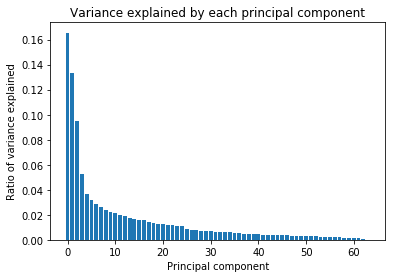

In [50]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each principal component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


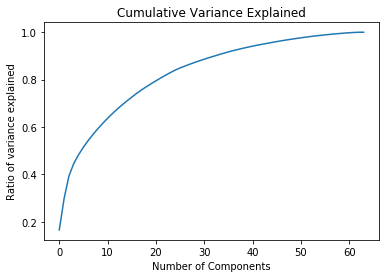

In [51]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

Text(0.5,1,'Explained Variance Per Principal Component\n')

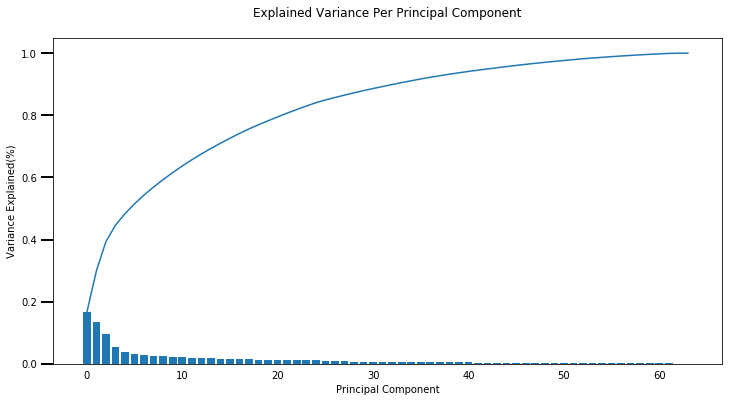

In [52]:
#another way
num_components = len(pca.explained_variance_ratio_)
inx = np.arange(num_components)
values = pca.explained_variance_ratio_
 
plt.figure(figsize=(12, 6))
ax = plt.subplot()
cumvalues = np.cumsum(values)
ax.bar(inx, values)
ax.plot(inx, cumvalues)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)
 
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained(%)")
plt.title('Explained Variance Per Principal Component\n')


In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
PCA_30 = PCA(n_components=30)
azdias_pca = PCA_30.fit_transform(azdias_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I retain 30 principal components, as the plot shown above these 30 component explains around 87% variances. I have retained 30 components for the next step. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
def pca_plot(data, pca, n):
    component_df = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n-1]
    component_df.sort_values(ascending=False, inplace=True)
    component_df = pd.concat([component_df.head(5), component_df.tail(5)])
    
    component_df.plot(kind='bar', title='Component ' + str(n))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

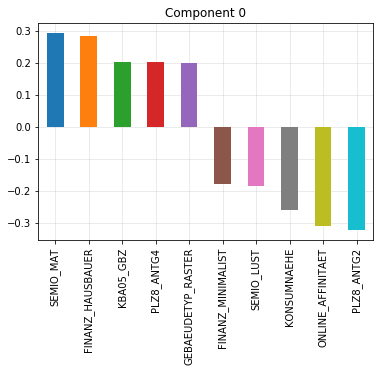

In [55]:
pca_plot(azdias_scaled, PCA_30, 0)

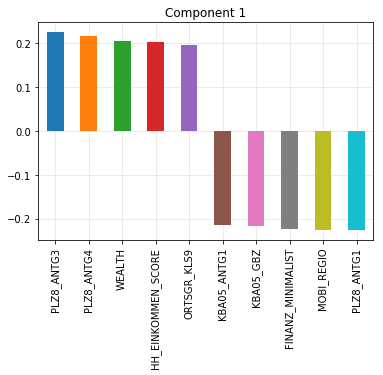

In [56]:
pca_plot(azdias_scaled, PCA_30, 1)

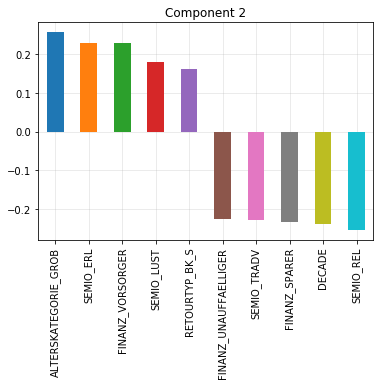

In [57]:
pca_plot(azdias_scaled, PCA_30, 2)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

We can interpret some relationships between the negative and positive weights, as well as relationships between positive weights together or negative weights together.

1- First principle component
* The component has a positive association with
    * FINANZ_HAUSBAUER (Financial typology)
    * SEMIO_MAT (Personality typology- materialistic)
* The component has a negative association with
    * ONLINE_AFFINITAET (Online affinity)
    * PLZ8_ANTG2 (Number of 3-5 family houses in the PLZ8 region)
    
if FINANZ_HAUSBAUER and SEMIO_MAT increase, the ONLINE_AFFINITAET and PLZ8_ANTG2 decrease.

2- Second principal component
* The component has a positive association with
    * PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
    * PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region)
* The component a has negative association with
    * MOBI_REGIO (Movement patterns)
    * PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region)
    
if PLZ8_ANTG3 and PLZ8_ANTG4 increase, the MOBI_REGIO and PLZ8_ANTG1 decrease.

3- Third principal component 
* The component has a positive association with
    * ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
    * SEMIO_ERL (Personality typology-event-oriented)
* The component has a negative association with
    * SEMIO_REL (Personality typology-religious)
    * DECADE

if ALTERSKATEGORIE_GROB and SEMIO_ERL increase, the SEMIO_REL and DECADE decrease.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [59]:
# Over a number of different cluster counts...
# run k-means clustering on the data
# compute the average within-cluster distances.
average=[]
for i in range(2,15,2):
    #k-means 
    kmeans = KMeans(n_clusters=i).fit(azdias_pca)
    #Obtain a score 
    score = np.abs(kmeans.score(azdias_pca))
    #average within-cluster distances. 
    average.append(score/azdias_pca.shape[0])

In [60]:
average 

[48.384182444356185,
 41.656418628036064,
 38.254375901142431,
 35.759558857310466,
 34.278052341632673,
 32.831498753259233,
 32.082124132979239]

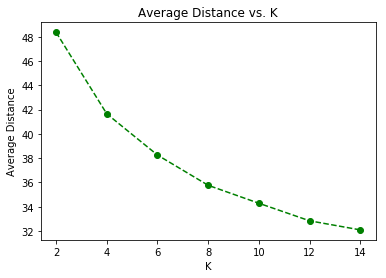

In [61]:
n=[2,4,6,8,10,12,14]
plt.plot(n, average, linestyle='--', marker='o', color='g');
plt.xlabel('K');
plt.ylabel('Average Distance');
plt.title('Average Distance vs. K');

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 14) 
model_14 = kmeans.fit(azdias_pca)
azdias_predict = model_14.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

To perform the k-means clustering I used Sklearn's KMeans class. It seems from the plot above that 14 is the elbow. Therefore I decided to use 14 clusters for the problem. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [63]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
customers.shape

(191652, 85)

In [64]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_new = clean_data(customers)

In [65]:
customers_new.shape

(191652, 64)

In [66]:
customers_new.isnull().sum().sum()

1975162

In [67]:
#discard nan
customers_imputed = pd.DataFrame(fill_strategy.fit_transform(customers_new))
customers_imputed.columns = customers_new.columns
customers_imputed.index = customers_new.index

In [68]:
customers_imputed.isnull().sum().sum()

0

In [69]:
#scale
customers_scaled = scaler.transform(customers_imputed)
customers_scaled = pd.DataFrame(customers_scaled, columns=list(customers_imputed))
customers_scaled.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.184106,-1.043935,1.409057,-1.155518,1.138172,-1.249985,-0.470407,-0.791205,1.885336,-1.633796,...,-0.934798,1.455847,1.485805,-2.174897,-1.432803,-1.525981,-1.633627,-1.885336,-1.551459,0.095099
1,1.184106,-1.043935,1.409057,-1.155518,1.138172,-1.249985,0.244119,-0.791205,-0.530409,-1.633796,...,-0.934798,-0.616366,-0.337195,-0.171400,-0.127041,-0.052072,-1.633627,0.530409,-0.869680,0.767095
2,1.184106,0.957914,1.409057,-1.155518,1.138172,-1.249985,0.958645,0.629141,1.885336,-0.311816,...,0.442528,-0.616366,-1.248695,-0.171400,-0.127041,-0.052072,-1.633627,-1.885336,-0.187901,0.767095


In [70]:
#PCA
customers_pca = PCA_30.transform(customers_scaled)

In [71]:
customers_pca

array([[-5.93792138,  0.60342806,  4.2474625 , ..., -0.09778868,
        -0.88245446, -0.86568477],
       [-3.81053315,  0.73355348,  3.28720905, ...,  0.05085946,
        -0.81239384,  0.30981216],
       [-1.75632229,  4.83170237, -0.62712056, ..., -1.19980118,
         0.483763  ,  0.74956375],
       ..., 
       [-4.57581493,  2.52934397,  2.44050466, ..., -0.82035201,
        -0.17378215,  1.38467399],
       [-1.15565701,  2.7299509 , -1.96074813, ...,  0.27487701,
         0.18955942,  1.50790829],
       [-3.61744694, -2.87747415,  2.27301764, ...,  1.57318584,
        -0.57459988,  0.77761952]])

In [72]:
#KMeans
customers_predict = model_14.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

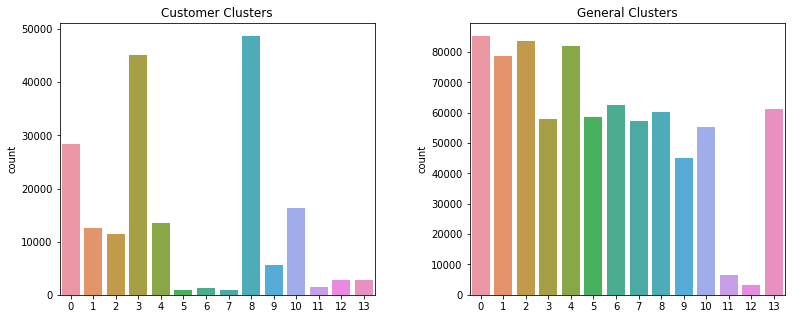

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (13,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_predict, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_predict, ax=axs[1])
axs[1].set_title('General Clusters')

In [74]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population? 
data_8 = scaler.inverse_transform(PCA_30.inverse_transform(model_14.cluster_centers_[8]))


In [75]:
overrepresented = pd.Series(data = data_8, index = customers_new.columns)

In [76]:
overrepresented

ALTERSKATEGORIE_GROB        1.784586
ANREDE_KZ                   1.963221
FINANZ_MINIMALIST           2.737554
FINANZ_SPARER               3.839432
FINANZ_VORSORGER            2.274131
FINANZ_ANLEGER              4.368437
FINANZ_UNAUFFAELLIGER       3.859373
FINANZ_HAUSBAUER            2.323104
GREEN_AVANTGARDE            0.245210
HEALTH_TYP                  2.257195
RETOURTYP_BK_S              2.522887
SEMIO_SOZ                   2.687856
SEMIO_FAM                   3.704878
SEMIO_REL                   5.209905
SEMIO_MAT                   5.109815
SEMIO_VERT                  2.671669
SEMIO_LUST                  3.106241
SEMIO_ERL                   4.398289
SEMIO_KULT                  4.060696
SEMIO_RAT                   6.165829
SEMIO_KRIT                  5.393552
SEMIO_DOM                   5.879757
SEMIO_KAEM                  5.559465
SEMIO_PFLICHT               6.000866
SEMIO_TRADV                 5.713885
SOHO_KZ                    -0.000021
VERS_TYP                    1.431618
A

In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
data_7 = scaler.inverse_transform(PCA_30.inverse_transform(model_14.cluster_centers_[7]))


In [78]:
underrepresented = pd.Series(data = data_7, index = customers_new.columns)

In [79]:
underrepresented

ALTERSKATEGORIE_GROB        1.632494
ANREDE_KZ                   2.003446
FINANZ_MINIMALIST           1.160337
FINANZ_SPARER               4.270873
FINANZ_VORSORGER            2.171896
FINANZ_ANLEGER              4.065489
FINANZ_UNAUFFAELLIGER       3.629240
FINANZ_HAUSBAUER            4.206474
GREEN_AVANTGARDE            0.030844
HEALTH_TYP                  2.260647
RETOURTYP_BK_S              2.698316
SEMIO_SOZ                   3.326362
SEMIO_FAM                   3.985663
SEMIO_REL                   5.450728
SEMIO_MAT                   5.003588
SEMIO_VERT                  2.229133
SEMIO_LUST                  3.024202
SEMIO_ERL                   4.252327
SEMIO_KULT                  4.226036
SEMIO_RAT                   6.235092
SEMIO_KRIT                  5.506301
SEMIO_DOM                   6.183029
SEMIO_KAEM                  6.241124
SEMIO_PFLICHT               6.304703
SEMIO_TRADV                 5.664420
SOHO_KZ                     0.000047
VERS_TYP                    1.515084
A

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the graph above we can see that the cluster points 8 is high likely to be customer segments because large amount of praportion  of customer data represented. In the other hand, the cluster points 7, 6 and 5 are less likely to be customers. 

Cluster 8 is overrepresented in the customer data compared to general populations. The following are some characteristics relatively popular with the mail-order company:

* The estimated age based on given name analysis is less than 30 years old (ALTERSKATEGORIE_GROB)
* The gender of the group is female (ANREDE_KZ)
* There is no 6-10 family homes share (PLZ8_ANTG3)
* In Prosperous or Comfortable households (WEALTH)
* Life stage of families with school-age children or older families & mature couples (LIFE_STAGE)

Cluster 7 is underrepresented in the customer data compared to general populations. The following are some characteristics relatively popular with the mail-order company: 

* The estimated age based on given name analysis is less than 30 years old (ALTERSKATEGORIE_GROB)
* The gender of the group is male (ANREDE_KZ)
* The share of 6-10 family homes is average (PLZ8_ANTG3)
* In less affluent or poorer households (WEALTH)
* Life stage of pre-family couples & singles or young couples with children (LIFE_STAGE)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.